In [63]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from astropy.io import ascii
import scipy
import emcee

In [64]:
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]
all_stars_in_selected_stars = all_stars_in_selected_stars[~np.isnan(all_stars_in_selected_stars["rrmscdpp06p0"])]

In [65]:
observation, _ = np.histogram(all_stars_in_selected_stars["nconfp"],bins = range(0,12))
N = np.sum(observation)
observation = torch.Tensor(observation)
y = torch.load("sims/data_y_mult_hist_fixstars_all")/N
x = torch.load("sims/data_x_params_fixstars_all")


In [66]:
class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(7, 64)     # First hidden layer (input: 5 units, output: 64 units)
        self.fc2 = nn.Linear(64, 128)   # Second hidden layer (input: 64 units, output: 128 units)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)   # Output layer (input: 128 units, output: 33 units)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 11)
                             
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, x):
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))      # Input to first layer and activation
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)      # Second layer and activation
        x = self.relu(self.fc3(x) )
        x = self.dropout(x)
        x = self.relu(self.fc4(x) )
        x = self.dropout(x)
        x = self.relu(self.fc5(x) )
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.log_softmax(self.fc7(x))        # Output layer (no activation if regression task)
        
        # logits_10 = self.fc7(x)  # 10 logits from the network
        # logit_0 = -torch.exp(torch.logsumexp(logits_10,1,keepdim=True))
    
        # logits_all = torch.cat([logit_0, logits_10], dim=-1)  # Concatenate with the 11th bin
        # log_probs = torch.log_softmax(logits_all, dim=-1)

        return x



model = Emulator()

model.eval()
model.load_state_dict(torch.load("best_model_0to10", weights_only=True))


<All keys matched successfully>

In [73]:
def log_like(theta):
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    log_probs = model(theta_tensor)
    #log_probs[log_probs<np.log(1/(np.e))] = np.log(1/(np.e))
    return torch.nansum(observation * log_probs)

def log_prior(theta):
    rcrit, alpha_small, alpha_big, sigma, sigma_i, b, eta = theta  # Unpack parameters
    
    # Example: uniform prior in some range
    if not (0.5 < rcrit < 32):  
        return -np.inf  # Outside prior range
    if not (20 > alpha_small > -1):
        return -np.inf
    if not (20 > alpha_big > -1):
        return -np.inf
    if not (20>sigma > 0):
        return -np.inf  
    if not (20>sigma_i > 0):
        return -np.inf
    if not (0 < b < 10):
        return -np.inf  
    if not (0 < eta < 1):
        return -np.inf
    
    return 0.0  # Flat prior (log(1) = 0)


def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_like(theta).item()



[]

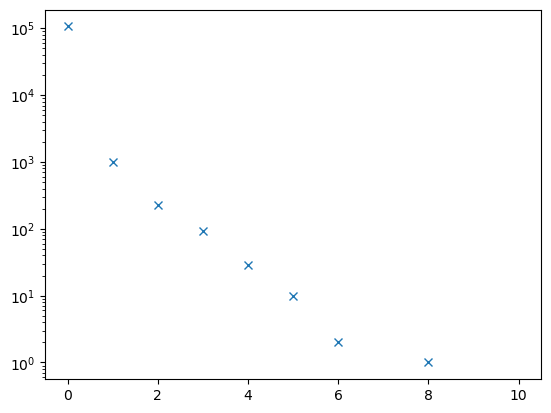

In [68]:
plt.plot(observation,"x")
plt.semilogy()

In [ ]:
ndim = 7  # Number of parameters
nwalkers = 4 * ndim  # Recommended: 2-4 times ndim
nsteps = 100000

# Initialize walkers around some random starting point
#p0 = np.random.randn(nwalkers, ndim)  

p0 = np.random.uniform(
    low=[3, 0, 2, 8, 1, 6, 0.1],  # Lower bounds
    high=[4, 2, 4, 10, 3, 8, 0.3],  # Upper bounds
    size=(nwalkers, ndim)
)



# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Run MCMC
print("Running MCMC...")
sampler.run_mcmc(p0, nsteps, progress=True)
print("Done.")


c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Running MCMC...


  7%|▋         | 7437/100000 [00:34<06:22, 242.23it/s]

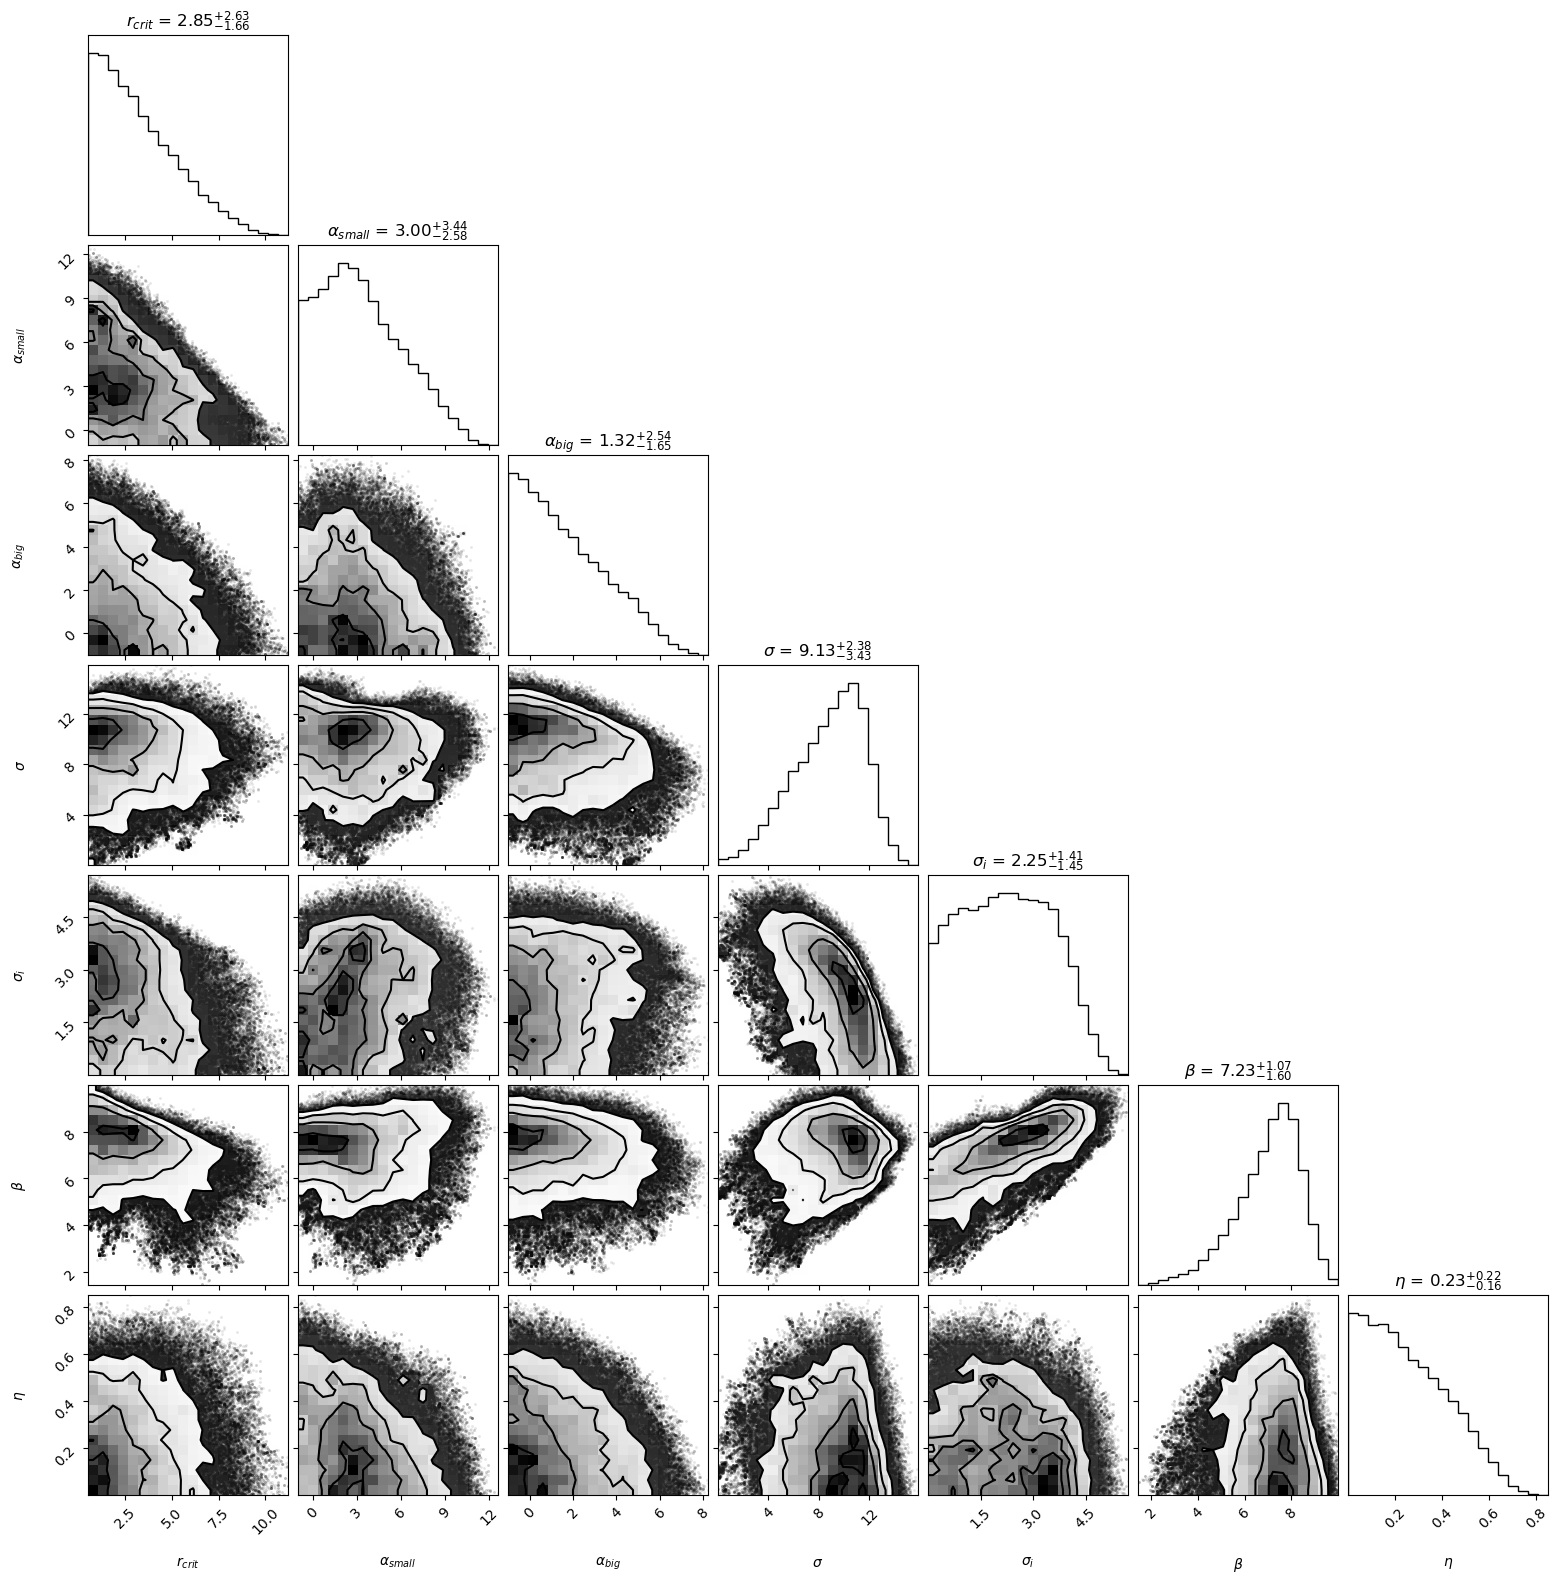

Best-fit parameters:
Theta 1: 2.847 ± 2.049
Theta 2: 2.998 ± 2.765
Theta 3: 1.322 ± 1.930
Theta 4: 9.131 ± 2.798
Theta 5: 2.247 ± 1.268
Theta 6: 7.228 ± 1.369
Theta 7: 0.230 ± 0.173


In [ ]:
import matplotlib.pyplot as plt
import corner

# Get the MCMC samples (discarding burn-in and thinning)
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

# Make a corner plot
labels = [r"$r_{crit}$",r"$\alpha_{small}$",r"$\alpha_{big}$",r"$\sigma$",r"$\sigma_i$",r"$\beta$",r"$\eta$"]
corner.corner(samples, labels=labels, show_titles=True)
plt.show()

# Compute best-fit parameters
theta_median = np.median(samples, axis=0)
theta_std = np.std(samples, axis=0)

print("Best-fit parameters:")
for i, (median, std) in enumerate(zip(theta_median, theta_std)):
    print(f"Theta {i+1}: {median:.3f} ± {std:.3f}")

plt.savefig("corner_plot_emcee.png")



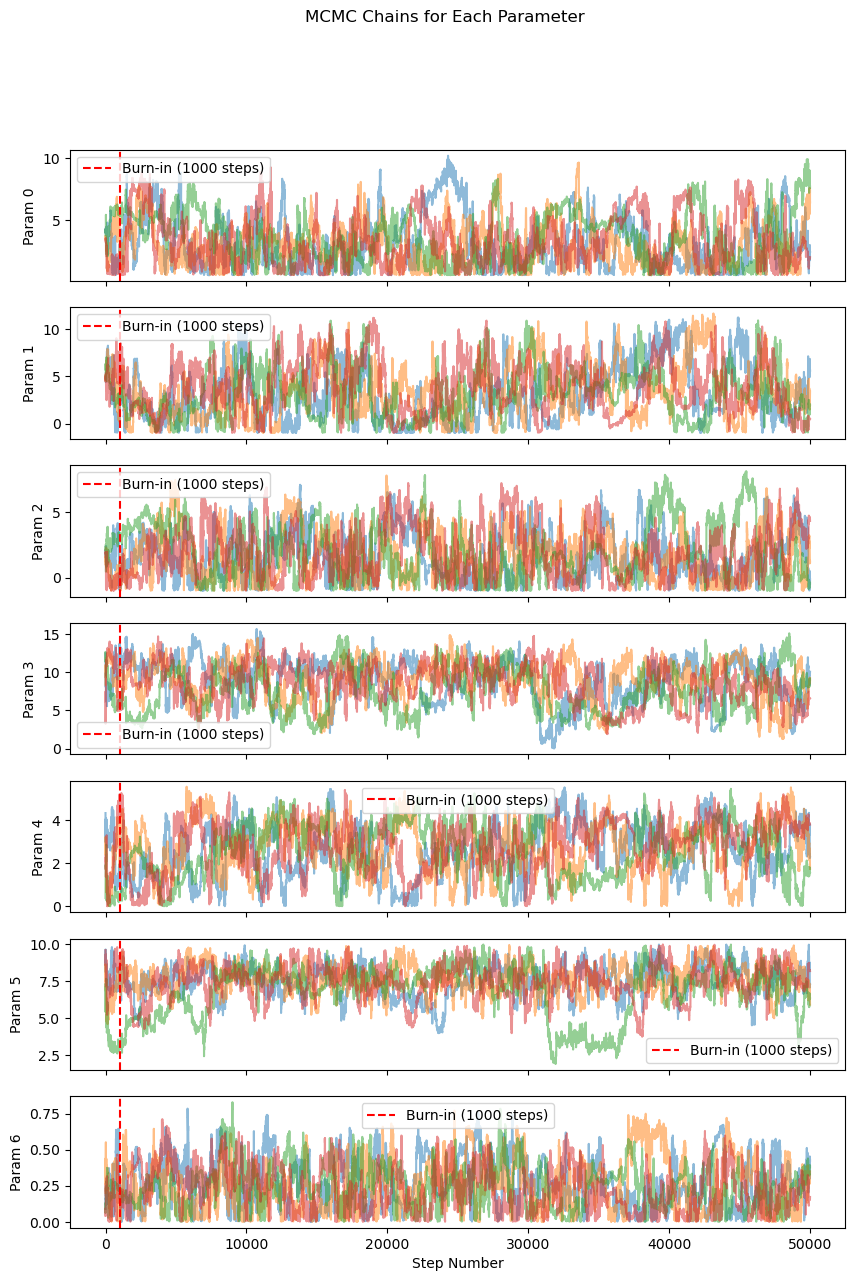

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Get the full chain (shape: nsteps, nwalkers, ndim)
chain = sampler.get_chain()

# Number of parameters
ndim = chain.shape[-1]

fig, axes = plt.subplots(ndim, figsize=(10, 2 * ndim), sharex=True)


for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[::2, ::8, i], alpha=0.5)  # Plot each walker
    ax.set_ylabel(f"Param {i}")
    ax.axvline(x=1000, color='r', linestyle='--', label="Burn-in (1000 steps)")
    ax.legend()

axes[-1].set_xlabel("Step Number")
plt.suptitle("MCMC Chains for Each Parameter")
plt.show()


c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


9.313226e-10
0.0
-1.17346644e-07
0.0
1.17346644e-07
1.1920929e-07
-9.313226e-10
2.3562461e-07
1.17346644e-07
9.313226e-10
1.17346644e-07
-9.313226e-10
1.17346644e-07
0.0
0.0
9.313226e-10
0.0
-2.3562461e-07
1.1827797e-07
0.0
9.313226e-10
0.0
0.0
-1.17346644e-07
-9.313226e-10
0.0
0.0
-9.313226e-10


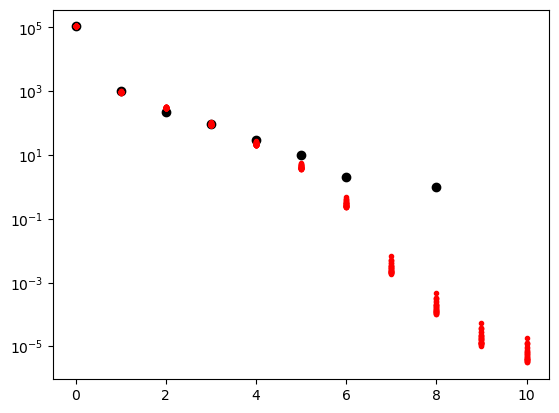

In [56]:
import scipy.special


plt.figure()
plt.plot(observation,"ko")
plt.semilogy()
for theta in chain[-1]:
    plt.plot(N*np.exp(model(torch.tensor(theta, dtype=torch.float32)).detach().numpy()), "r.")
    print(scipy.special.logsumexp(model(torch.tensor(theta, dtype=torch.float32)).detach().numpy()))


In [57]:
100*observation[0]/N

tensor(98.7455)